In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 2:2+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/27-35/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 25  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(9, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(9, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 9)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 9)
valid_labels[0].shape = (224, 224, 1)



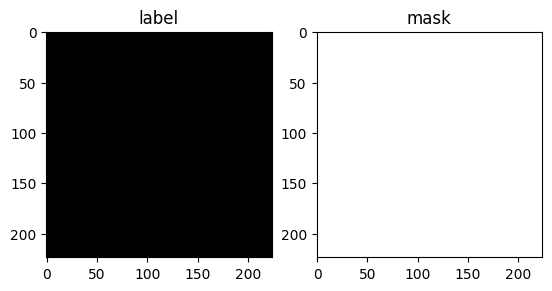

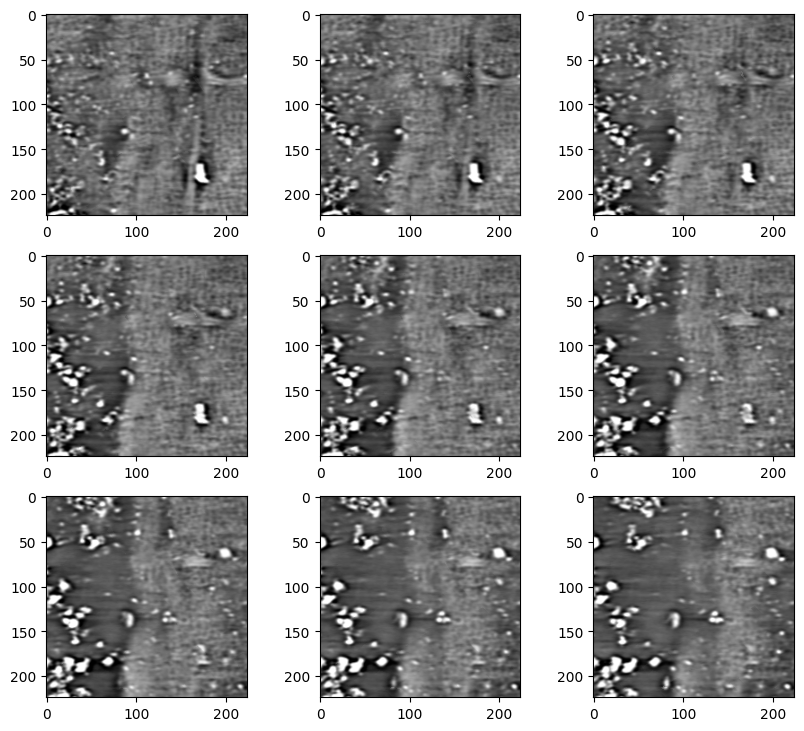

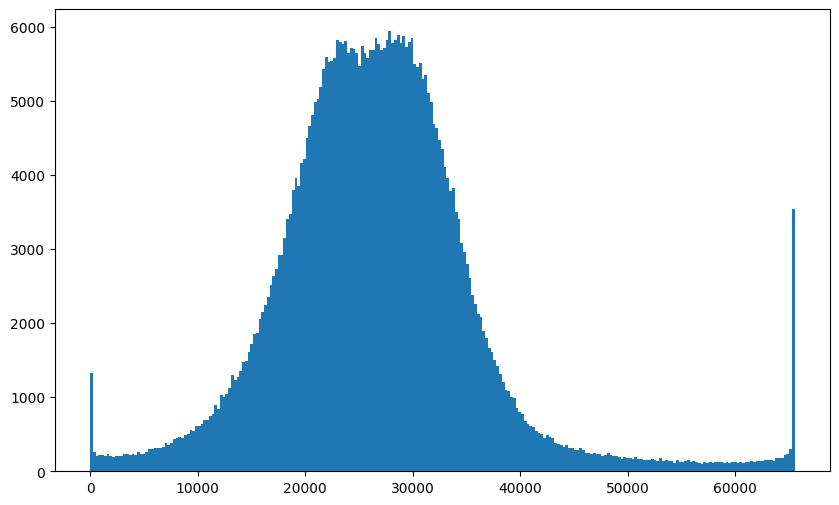

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


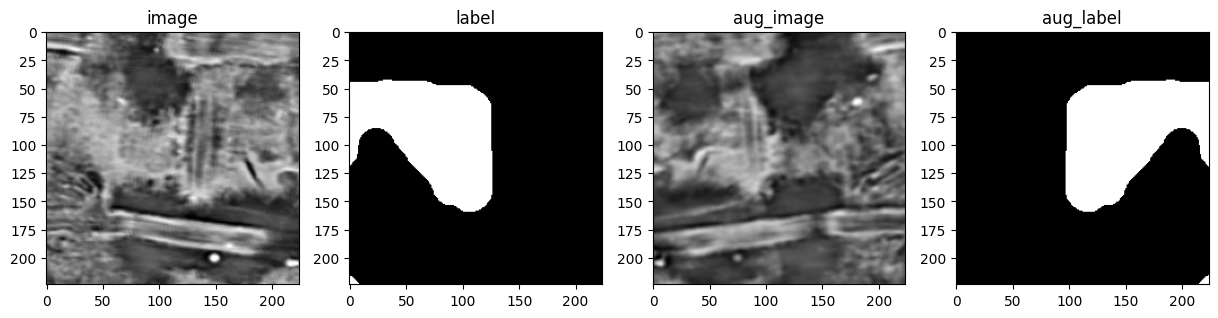

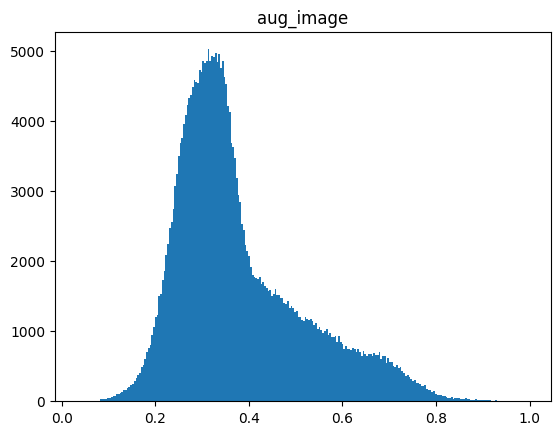

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|██████████| 131/131 [00:07<00:00, 17.50it/s]


fbeta: 0.3474
Epoch 1 - avg_train_loss: 1.3890  avg_val_loss: 1.1214  avgScore: 0.3474  time: 84s
Epoch 1 - Save Best Loss: 1.1214  Best Score: 0.3474 Model



100%|██████████| 131/131 [00:07<00:00, 18.06it/s]


fbeta: 0.3733
Epoch 2 - avg_train_loss: 1.1823  avg_val_loss: 1.0440  avgScore: 0.3733  time: 79s
Epoch 2 - Save Best Loss: 1.0440  Best Score: 0.3733 Model



100%|██████████| 131/131 [00:07<00:00, 18.08it/s]


fbeta: 0.4604
Epoch 3 - avg_train_loss: 1.0029  avg_val_loss: 0.9128  avgScore: 0.4604  time: 79s
Epoch 3 - Save Best Loss: 0.9128  Best Score: 0.4604 Model



100%|██████████| 131/131 [00:07<00:00, 17.88it/s]


fbeta: 0.3695
Epoch 4 - avg_train_loss: 0.8863  avg_val_loss: 0.9611  avgScore: 0.3695  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.4075
Epoch 5 - avg_train_loss: 0.8494  avg_val_loss: 0.9123  avgScore: 0.4075  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.01it/s]


fbeta: 0.4207
Epoch 6 - avg_train_loss: 0.8266  avg_val_loss: 0.9446  avgScore: 0.4207  time: 79s



100%|██████████| 131/131 [00:07<00:00, 17.89it/s]


fbeta: 0.4920
Epoch 7 - avg_train_loss: 0.7683  avg_val_loss: 0.8718  avgScore: 0.4920  time: 79s
Epoch 7 - Save Best Loss: 0.8718  Best Score: 0.4920 Model



100%|██████████| 131/131 [00:07<00:00, 17.82it/s]


fbeta: 0.4909
Epoch 8 - avg_train_loss: 0.7540  avg_val_loss: 0.8837  avgScore: 0.4909  time: 79s



100%|██████████| 131/131 [00:07<00:00, 17.77it/s]


fbeta: 0.5010
Epoch 9 - avg_train_loss: 0.7046  avg_val_loss: 0.8744  avgScore: 0.5010  time: 79s
Epoch 9 - Save Best Loss: 0.8744  Best Score: 0.5010 Model



100%|██████████| 131/131 [00:07<00:00, 17.78it/s]


fbeta: 0.5228
Epoch 10 - avg_train_loss: 0.6773  avg_val_loss: 0.9773  avgScore: 0.5228  time: 78s
Epoch 10 - Save Best Loss: 0.9773  Best Score: 0.5228 Model



100%|██████████| 131/131 [00:07<00:00, 17.78it/s]


fbeta: 0.4449
Epoch 11 - avg_train_loss: 0.6960  avg_val_loss: 0.9480  avgScore: 0.4449  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.4997
Epoch 12 - avg_train_loss: 0.6589  avg_val_loss: 0.9378  avgScore: 0.4997  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.19it/s]


fbeta: 0.5252
Epoch 13 - avg_train_loss: 0.6237  avg_val_loss: 0.8927  avgScore: 0.5252  time: 77s
Epoch 13 - Save Best Loss: 0.8927  Best Score: 0.5252 Model



100%|██████████| 131/131 [00:07<00:00, 17.93it/s]


fbeta: 0.5429
Epoch 14 - avg_train_loss: 0.5676  avg_val_loss: 1.0013  avgScore: 0.5429  time: 78s
Epoch 14 - Save Best Loss: 1.0013  Best Score: 0.5429 Model



100%|██████████| 131/131 [00:07<00:00, 18.04it/s]


fbeta: 0.5531
Epoch 15 - avg_train_loss: 0.5862  avg_val_loss: 0.8429  avgScore: 0.5531  time: 79s
Epoch 15 - Save Best Loss: 0.8429  Best Score: 0.5531 Model



100%|██████████| 131/131 [00:07<00:00, 17.94it/s]


fbeta: 0.5011
Epoch 16 - avg_train_loss: 0.5520  avg_val_loss: 0.8873  avgScore: 0.5011  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.18it/s]


fbeta: 0.5246
Epoch 17 - avg_train_loss: 0.5359  avg_val_loss: 0.8551  avgScore: 0.5246  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.04it/s]


fbeta: 0.5277
Epoch 18 - avg_train_loss: 0.5072  avg_val_loss: 0.9199  avgScore: 0.5277  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.17it/s]


fbeta: 0.5384
Epoch 19 - avg_train_loss: 0.4909  avg_val_loss: 0.9024  avgScore: 0.5384  time: 77s



100%|██████████| 131/131 [00:07<00:00, 18.07it/s]


fbeta: 0.5303
Epoch 20 - avg_train_loss: 0.4653  avg_val_loss: 0.9736  avgScore: 0.5303  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.11it/s]


fbeta: 0.5156
Epoch 21 - avg_train_loss: 0.4511  avg_val_loss: 0.9477  avgScore: 0.5156  time: 79s



100%|██████████| 131/131 [00:07<00:00, 18.13it/s]


fbeta: 0.5349
Epoch 22 - avg_train_loss: 0.4493  avg_val_loss: 0.9332  avgScore: 0.5349  time: 77s



100%|██████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.5532
Epoch 23 - avg_train_loss: 0.4383  avg_val_loss: 0.9235  avgScore: 0.5532  time: 78s
Epoch 23 - Save Best Loss: 0.9235  Best Score: 0.5532 Model



100%|██████████| 131/131 [00:07<00:00, 18.05it/s]


fbeta: 0.5266
Epoch 24 - avg_train_loss: 0.4226  avg_val_loss: 0.9367  avgScore: 0.5266  time: 78s



100%|██████████| 131/131 [00:07<00:00, 18.19it/s]


fbeta: 0.5596
Epoch 25 - avg_train_loss: 0.4240  avg_val_loss: 0.9127  avgScore: 0.5596  time: 78s
Epoch 25 - Save Best Loss: 0.9127  Best Score: 0.5596 Model

fold: 1


100%|██████████| 120/120 [00:06<00:00, 17.69it/s]


fbeta: 0.2232
Epoch 1 - avg_train_loss: 1.4615  avg_val_loss: 0.8932  avgScore: 0.2232  time: 79s
Epoch 1 - Save Best Loss: 0.8932  Best Score: 0.2232 Model



100%|██████████| 120/120 [00:06<00:00, 17.70it/s]


fbeta: 0.3200
Epoch 2 - avg_train_loss: 1.2458  avg_val_loss: 0.8359  avgScore: 0.3200  time: 80s
Epoch 2 - Save Best Loss: 0.8359  Best Score: 0.3200 Model



100%|██████████| 120/120 [00:06<00:00, 17.98it/s]


fbeta: 0.5019
Epoch 3 - avg_train_loss: 1.0676  avg_val_loss: 0.6625  avgScore: 0.5019  time: 78s
Epoch 3 - Save Best Loss: 0.6625  Best Score: 0.5019 Model



100%|██████████| 120/120 [00:06<00:00, 18.04it/s]


fbeta: 0.4892
Epoch 4 - avg_train_loss: 0.9136  avg_val_loss: 0.6237  avgScore: 0.4892  time: 80s



100%|██████████| 120/120 [00:06<00:00, 18.03it/s]


fbeta: 0.4176
Epoch 5 - avg_train_loss: 0.8772  avg_val_loss: 0.6745  avgScore: 0.4176  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.05it/s]


fbeta: 0.4882
Epoch 6 - avg_train_loss: 0.8300  avg_val_loss: 0.6102  avgScore: 0.4882  time: 78s



100%|██████████| 120/120 [00:06<00:00, 18.02it/s]


fbeta: 0.4855
Epoch 7 - avg_train_loss: 0.7887  avg_val_loss: 0.6024  avgScore: 0.4855  time: 78s



100%|██████████| 120/120 [00:06<00:00, 17.89it/s]


fbeta: 0.5601
Epoch 8 - avg_train_loss: 0.7497  avg_val_loss: 0.5971  avgScore: 0.5601  time: 79s
Epoch 8 - Save Best Loss: 0.5971  Best Score: 0.5601 Model



100%|██████████| 120/120 [00:06<00:00, 17.86it/s]


fbeta: 0.5584
Epoch 9 - avg_train_loss: 0.6992  avg_val_loss: 0.5880  avgScore: 0.5584  time: 79s



100%|██████████| 120/120 [00:06<00:00, 17.92it/s]


fbeta: 0.4374
Epoch 10 - avg_train_loss: 0.7130  avg_val_loss: 0.6406  avgScore: 0.4374  time: 79s



100%|██████████| 120/120 [00:06<00:00, 17.97it/s]


fbeta: 0.5467
Epoch 11 - avg_train_loss: 0.6865  avg_val_loss: 0.6167  avgScore: 0.5467  time: 79s



100%|██████████| 120/120 [00:06<00:00, 17.87it/s]


fbeta: 0.4608
Epoch 12 - avg_train_loss: 0.6518  avg_val_loss: 0.6279  avgScore: 0.4608  time: 80s



100%|██████████| 120/120 [00:06<00:00, 18.02it/s]


fbeta: 0.5538
Epoch 13 - avg_train_loss: 0.6206  avg_val_loss: 0.6077  avgScore: 0.5538  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.12it/s]


fbeta: 0.5595
Epoch 14 - avg_train_loss: 0.5968  avg_val_loss: 0.6259  avgScore: 0.5595  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.07it/s]


fbeta: 0.5453
Epoch 15 - avg_train_loss: 0.5669  avg_val_loss: 0.6433  avgScore: 0.5453  time: 78s



100%|██████████| 120/120 [00:06<00:00, 17.99it/s]


fbeta: 0.5863
Epoch 16 - avg_train_loss: 0.5553  avg_val_loss: 0.6108  avgScore: 0.5863  time: 78s
Epoch 16 - Save Best Loss: 0.6108  Best Score: 0.5863 Model



100%|██████████| 120/120 [00:06<00:00, 17.89it/s]


fbeta: 0.5678
Epoch 17 - avg_train_loss: 0.5314  avg_val_loss: 0.6404  avgScore: 0.5678  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.02it/s]


fbeta: 0.5784
Epoch 18 - avg_train_loss: 0.5033  avg_val_loss: 0.6077  avgScore: 0.5784  time: 80s



100%|██████████| 120/120 [00:06<00:00, 18.03it/s]


fbeta: 0.5432
Epoch 19 - avg_train_loss: 0.4874  avg_val_loss: 0.6323  avgScore: 0.5432  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.07it/s]


fbeta: 0.5121
Epoch 20 - avg_train_loss: 0.4708  avg_val_loss: 0.6243  avgScore: 0.5121  time: 78s



100%|██████████| 120/120 [00:06<00:00, 18.12it/s]


fbeta: 0.5626
Epoch 21 - avg_train_loss: 0.4525  avg_val_loss: 0.6217  avgScore: 0.5626  time: 78s



100%|██████████| 120/120 [00:06<00:00, 17.99it/s]


fbeta: 0.5472
Epoch 22 - avg_train_loss: 0.4413  avg_val_loss: 0.6290  avgScore: 0.5472  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.03it/s]


fbeta: 0.5567
Epoch 23 - avg_train_loss: 0.4343  avg_val_loss: 0.6279  avgScore: 0.5567  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.00it/s]


fbeta: 0.5650
Epoch 24 - avg_train_loss: 0.4209  avg_val_loss: 0.6370  avgScore: 0.5650  time: 78s



100%|██████████| 120/120 [00:06<00:00, 18.09it/s]


fbeta: 0.5434
Epoch 25 - avg_train_loss: 0.4232  avg_val_loss: 0.6351  avgScore: 0.5434  time: 78s

fold: 2


100%|██████████| 120/120 [00:06<00:00, 18.08it/s]


fbeta: 0.3498
Epoch 1 - avg_train_loss: 1.1551  avg_val_loss: 1.1908  avgScore: 0.3498  time: 80s
Epoch 1 - Save Best Loss: 1.1908  Best Score: 0.3498 Model



100%|██████████| 120/120 [00:06<00:00, 17.89it/s]


fbeta: 0.4541
Epoch 2 - avg_train_loss: 1.0373  avg_val_loss: 1.1015  avgScore: 0.4541  time: 80s
Epoch 2 - Save Best Loss: 1.1015  Best Score: 0.4541 Model



100%|██████████| 120/120 [00:06<00:00, 18.14it/s]


fbeta: 0.3765
Epoch 3 - avg_train_loss: 0.9441  avg_val_loss: 1.1736  avgScore: 0.3765  time: 78s



100%|██████████| 120/120 [00:06<00:00, 18.10it/s]


fbeta: 0.4406
Epoch 4 - avg_train_loss: 0.8722  avg_val_loss: 1.1358  avgScore: 0.4406  time: 78s



100%|██████████| 120/120 [00:06<00:00, 18.05it/s]


fbeta: 0.5166
Epoch 5 - avg_train_loss: 0.8215  avg_val_loss: 1.0775  avgScore: 0.5166  time: 78s
Epoch 5 - Save Best Loss: 1.0775  Best Score: 0.5166 Model



100%|██████████| 120/120 [00:06<00:00, 18.14it/s]


fbeta: 0.5210
Epoch 6 - avg_train_loss: 0.7959  avg_val_loss: 1.0674  avgScore: 0.5210  time: 79s
Epoch 6 - Save Best Loss: 1.0674  Best Score: 0.5210 Model



100%|██████████| 120/120 [00:06<00:00, 18.10it/s]


fbeta: 0.5462
Epoch 7 - avg_train_loss: 0.7582  avg_val_loss: 1.0376  avgScore: 0.5462  time: 79s
Epoch 7 - Save Best Loss: 1.0376  Best Score: 0.5462 Model



100%|██████████| 120/120 [00:06<00:00, 18.20it/s]


fbeta: 0.5253
Epoch 8 - avg_train_loss: 0.7074  avg_val_loss: 1.0446  avgScore: 0.5253  time: 78s



100%|██████████| 120/120 [00:06<00:00, 18.05it/s]


fbeta: 0.5546
Epoch 9 - avg_train_loss: 0.6941  avg_val_loss: 1.1013  avgScore: 0.5546  time: 79s
Epoch 9 - Save Best Loss: 1.1013  Best Score: 0.5546 Model



100%|██████████| 120/120 [00:06<00:00, 18.07it/s]


fbeta: 0.4928
Epoch 10 - avg_train_loss: 0.6791  avg_val_loss: 1.1482  avgScore: 0.4928  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.12it/s]


fbeta: 0.5650
Epoch 11 - avg_train_loss: 0.6864  avg_val_loss: 1.0751  avgScore: 0.5650  time: 79s
Epoch 11 - Save Best Loss: 1.0751  Best Score: 0.5650 Model



100%|██████████| 120/120 [00:06<00:00, 18.11it/s]


fbeta: 0.5695
Epoch 12 - avg_train_loss: 0.6403  avg_val_loss: 1.0630  avgScore: 0.5695  time: 79s
Epoch 12 - Save Best Loss: 1.0630  Best Score: 0.5695 Model



100%|██████████| 120/120 [00:06<00:00, 18.07it/s]


fbeta: 0.5334
Epoch 13 - avg_train_loss: 0.6148  avg_val_loss: 1.1171  avgScore: 0.5334  time: 79s



100%|██████████| 120/120 [00:06<00:00, 18.18it/s]


fbeta: 0.5694
Epoch 14 - avg_train_loss: 0.5840  avg_val_loss: 1.0530  avgScore: 0.5694  time: 78s



100%|██████████| 120/120 [00:06<00:00, 17.53it/s]


fbeta: 0.5622
Epoch 15 - avg_train_loss: 0.5753  avg_val_loss: 1.1443  avgScore: 0.5622  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.69it/s]


fbeta: 0.5813
Epoch 16 - avg_train_loss: 0.5375  avg_val_loss: 1.1252  avgScore: 0.5813  time: 81s
Epoch 16 - Save Best Loss: 1.1252  Best Score: 0.5813 Model



100%|██████████| 120/120 [00:06<00:00, 17.82it/s]


fbeta: 0.5501
Epoch 17 - avg_train_loss: 0.5395  avg_val_loss: 1.1578  avgScore: 0.5501  time: 81s



100%|██████████| 120/120 [00:06<00:00, 18.06it/s]


fbeta: 0.5713
Epoch 18 - avg_train_loss: 0.5130  avg_val_loss: 1.0940  avgScore: 0.5713  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.85it/s]


fbeta: 0.5536
Epoch 19 - avg_train_loss: 0.4878  avg_val_loss: 1.1701  avgScore: 0.5536  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.48it/s]


fbeta: 0.5712
Epoch 20 - avg_train_loss: 0.4716  avg_val_loss: 1.1528  avgScore: 0.5712  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.41it/s]


fbeta: 0.5815
Epoch 21 - avg_train_loss: 0.4683  avg_val_loss: 1.1945  avgScore: 0.5815  time: 81s
Epoch 21 - Save Best Loss: 1.1945  Best Score: 0.5815 Model



100%|██████████| 120/120 [00:06<00:00, 17.45it/s]


fbeta: 0.5695
Epoch 22 - avg_train_loss: 0.4523  avg_val_loss: 1.2047  avgScore: 0.5695  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.61it/s]


fbeta: 0.5591
Epoch 23 - avg_train_loss: 0.4427  avg_val_loss: 1.1826  avgScore: 0.5591  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.54it/s]


fbeta: 0.5762
Epoch 24 - avg_train_loss: 0.4342  avg_val_loss: 1.1687  avgScore: 0.5762  time: 82s



100%|██████████| 120/120 [00:06<00:00, 17.54it/s]


fbeta: 0.5643
Epoch 25 - avg_train_loss: 0.4329  avg_val_loss: 1.2056  avgScore: 0.5643  time: 81s

fold: 3


100%|██████████| 120/120 [00:06<00:00, 17.70it/s]


fbeta: 0.3547
Epoch 1 - avg_train_loss: 1.3818  avg_val_loss: 1.1325  avgScore: 0.3547  time: 81s
Epoch 1 - Save Best Loss: 1.1325  Best Score: 0.3547 Model



100%|██████████| 120/120 [00:06<00:00, 17.61it/s]


fbeta: 0.4265
Epoch 2 - avg_train_loss: 1.1237  avg_val_loss: 1.0425  avgScore: 0.4265  time: 80s
Epoch 2 - Save Best Loss: 1.0425  Best Score: 0.4265 Model



100%|██████████| 120/120 [00:06<00:00, 17.94it/s]


fbeta: 0.3861
Epoch 3 - avg_train_loss: 0.9831  avg_val_loss: 1.0265  avgScore: 0.3861  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.20it/s]


fbeta: 0.4952
Epoch 4 - avg_train_loss: 0.8734  avg_val_loss: 0.9446  avgScore: 0.4952  time: 80s
Epoch 4 - Save Best Loss: 0.9446  Best Score: 0.4952 Model



100%|██████████| 120/120 [00:06<00:00, 18.00it/s]


fbeta: 0.5619
Epoch 5 - avg_train_loss: 0.8140  avg_val_loss: 0.9011  avgScore: 0.5619  time: 79s
Epoch 5 - Save Best Loss: 0.9011  Best Score: 0.5619 Model



100%|██████████| 120/120 [00:06<00:00, 17.54it/s]


fbeta: 0.4727
Epoch 6 - avg_train_loss: 0.8127  avg_val_loss: 1.0221  avgScore: 0.4727  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.52it/s]


fbeta: 0.5938
Epoch 7 - avg_train_loss: 0.7912  avg_val_loss: 0.8800  avgScore: 0.5938  time: 81s
Epoch 7 - Save Best Loss: 0.8800  Best Score: 0.5938 Model



100%|██████████| 120/120 [00:06<00:00, 17.91it/s]


fbeta: 0.5987
Epoch 8 - avg_train_loss: 0.7355  avg_val_loss: 0.9261  avgScore: 0.5987  time: 81s
Epoch 8 - Save Best Loss: 0.9261  Best Score: 0.5987 Model



100%|██████████| 120/120 [00:06<00:00, 17.53it/s]


fbeta: 0.5890
Epoch 9 - avg_train_loss: 0.7397  avg_val_loss: 0.9448  avgScore: 0.5890  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.56it/s]


fbeta: 0.6149
Epoch 10 - avg_train_loss: 0.7067  avg_val_loss: 0.8895  avgScore: 0.6149  time: 80s
Epoch 10 - Save Best Loss: 0.8895  Best Score: 0.6149 Model



100%|██████████| 120/120 [00:06<00:00, 17.47it/s]


fbeta: 0.6029
Epoch 11 - avg_train_loss: 0.6733  avg_val_loss: 0.8544  avgScore: 0.6029  time: 81s



100%|██████████| 120/120 [00:06<00:00, 18.00it/s]


fbeta: 0.5270
Epoch 12 - avg_train_loss: 0.6705  avg_val_loss: 0.9583  avgScore: 0.5270  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.91it/s]


fbeta: 0.6159
Epoch 13 - avg_train_loss: 0.6352  avg_val_loss: 0.8503  avgScore: 0.6159  time: 80s
Epoch 13 - Save Best Loss: 0.8503  Best Score: 0.6159 Model



100%|██████████| 120/120 [00:06<00:00, 18.00it/s]


fbeta: 0.5538
Epoch 14 - avg_train_loss: 0.6272  avg_val_loss: 0.9067  avgScore: 0.5538  time: 79s



100%|██████████| 120/120 [00:06<00:00, 17.99it/s]


fbeta: 0.5986
Epoch 15 - avg_train_loss: 0.6027  avg_val_loss: 0.8650  avgScore: 0.5986  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.58it/s]


fbeta: 0.6368
Epoch 16 - avg_train_loss: 0.5913  avg_val_loss: 0.8663  avgScore: 0.6368  time: 80s
Epoch 16 - Save Best Loss: 0.8663  Best Score: 0.6368 Model



100%|██████████| 120/120 [00:06<00:00, 17.39it/s]


fbeta: 0.6022
Epoch 17 - avg_train_loss: 0.5566  avg_val_loss: 0.9124  avgScore: 0.6022  time: 82s



100%|██████████| 120/120 [00:06<00:00, 17.60it/s]


fbeta: 0.6025
Epoch 18 - avg_train_loss: 0.5273  avg_val_loss: 0.9042  avgScore: 0.6025  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.55it/s]


fbeta: 0.6369
Epoch 19 - avg_train_loss: 0.4983  avg_val_loss: 0.9137  avgScore: 0.6369  time: 81s
Epoch 19 - Save Best Loss: 0.9137  Best Score: 0.6369 Model



100%|██████████| 120/120 [00:06<00:00, 17.84it/s]


fbeta: 0.5780
Epoch 20 - avg_train_loss: 0.4874  avg_val_loss: 0.9356  avgScore: 0.5780  time: 80s



100%|██████████| 120/120 [00:06<00:00, 17.50it/s]


fbeta: 0.6014
Epoch 21 - avg_train_loss: 0.4790  avg_val_loss: 0.9568  avgScore: 0.6014  time: 82s



100%|██████████| 120/120 [00:06<00:00, 17.59it/s]


fbeta: 0.6195
Epoch 22 - avg_train_loss: 0.4720  avg_val_loss: 0.9064  avgScore: 0.6195  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.63it/s]


fbeta: 0.6280
Epoch 23 - avg_train_loss: 0.4589  avg_val_loss: 0.9590  avgScore: 0.6280  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.59it/s]


fbeta: 0.6168
Epoch 24 - avg_train_loss: 0.4420  avg_val_loss: 0.9346  avgScore: 0.6168  time: 81s



100%|██████████| 120/120 [00:06<00:00, 17.47it/s]


fbeta: 0.6312
Epoch 25 - avg_train_loss: 0.4423  avg_val_loss: 0.9326  avgScore: 0.6312  time: 82s

fold: 4


100%|██████████| 99/99 [00:05<00:00, 18.03it/s]


fbeta: 0.3357
Epoch 1 - avg_train_loss: 1.2942  avg_val_loss: 1.0314  avgScore: 0.3357  time: 84s
Epoch 1 - Save Best Loss: 1.0314  Best Score: 0.3357 Model



100%|██████████| 99/99 [00:05<00:00, 17.15it/s]


fbeta: 0.4122
Epoch 2 - avg_train_loss: 1.1274  avg_val_loss: 0.9110  avgScore: 0.4122  time: 83s
Epoch 2 - Save Best Loss: 0.9110  Best Score: 0.4122 Model



100%|██████████| 99/99 [00:05<00:00, 17.74it/s]


fbeta: 0.3786
Epoch 3 - avg_train_loss: 0.9931  avg_val_loss: 0.8144  avgScore: 0.3786  time: 82s



100%|██████████| 99/99 [00:05<00:00, 18.10it/s]


fbeta: 0.4364
Epoch 4 - avg_train_loss: 0.8635  avg_val_loss: 0.7512  avgScore: 0.4364  time: 82s
Epoch 4 - Save Best Loss: 0.7512  Best Score: 0.4364 Model



100%|██████████| 99/99 [00:05<00:00, 17.64it/s]


fbeta: 0.4874
Epoch 5 - avg_train_loss: 0.8438  avg_val_loss: 0.7167  avgScore: 0.4874  time: 84s
Epoch 5 - Save Best Loss: 0.7167  Best Score: 0.4874 Model



100%|██████████| 99/99 [00:05<00:00, 17.59it/s]


fbeta: 0.4201
Epoch 6 - avg_train_loss: 0.8068  avg_val_loss: 0.8013  avgScore: 0.4201  time: 83s



100%|██████████| 99/99 [00:05<00:00, 17.85it/s]


fbeta: 0.4254
Epoch 7 - avg_train_loss: 0.7692  avg_val_loss: 0.7674  avgScore: 0.4254  time: 83s



100%|██████████| 99/99 [00:05<00:00, 17.57it/s]


fbeta: 0.3840
Epoch 8 - avg_train_loss: 0.7386  avg_val_loss: 0.8422  avgScore: 0.3840  time: 82s



100%|██████████| 99/99 [00:05<00:00, 17.57it/s]


fbeta: 0.4494
Epoch 9 - avg_train_loss: 0.7295  avg_val_loss: 0.7472  avgScore: 0.4494  time: 84s



100%|██████████| 99/99 [00:05<00:00, 17.20it/s]


fbeta: 0.5562
Epoch 10 - avg_train_loss: 0.6641  avg_val_loss: 0.6798  avgScore: 0.5562  time: 83s
Epoch 10 - Save Best Loss: 0.6798  Best Score: 0.5562 Model



100%|██████████| 99/99 [00:05<00:00, 17.92it/s]


fbeta: 0.4826
Epoch 11 - avg_train_loss: 0.6482  avg_val_loss: 0.7170  avgScore: 0.4826  time: 83s



100%|██████████| 99/99 [00:05<00:00, 18.04it/s]


fbeta: 0.5061
Epoch 12 - avg_train_loss: 0.6576  avg_val_loss: 0.7162  avgScore: 0.5061  time: 81s



100%|██████████| 99/99 [00:05<00:00, 17.99it/s]


fbeta: 0.5068
Epoch 13 - avg_train_loss: 0.6281  avg_val_loss: 0.7132  avgScore: 0.5068  time: 83s



100%|██████████| 99/99 [00:05<00:00, 17.97it/s]


fbeta: 0.4219
Epoch 14 - avg_train_loss: 0.6139  avg_val_loss: 0.8004  avgScore: 0.4219  time: 81s



100%|██████████| 99/99 [00:05<00:00, 17.98it/s]


fbeta: 0.4616
Epoch 15 - avg_train_loss: 0.5726  avg_val_loss: 0.7609  avgScore: 0.4616  time: 80s



100%|██████████| 99/99 [00:05<00:00, 17.96it/s]


fbeta: 0.4372
Epoch 16 - avg_train_loss: 0.5508  avg_val_loss: 0.7956  avgScore: 0.4372  time: 80s



100%|██████████| 99/99 [00:05<00:00, 17.97it/s]


fbeta: 0.4457
Epoch 17 - avg_train_loss: 0.5341  avg_val_loss: 0.7799  avgScore: 0.4457  time: 81s



100%|██████████| 99/99 [00:05<00:00, 17.99it/s]


fbeta: 0.4713
Epoch 18 - avg_train_loss: 0.5083  avg_val_loss: 0.7392  avgScore: 0.4713  time: 82s



100%|██████████| 99/99 [00:05<00:00, 17.99it/s]


fbeta: 0.5102
Epoch 19 - avg_train_loss: 0.5030  avg_val_loss: 0.7198  avgScore: 0.5102  time: 82s



100%|██████████| 99/99 [00:05<00:00, 17.88it/s]


fbeta: 0.4685
Epoch 20 - avg_train_loss: 0.4805  avg_val_loss: 0.7595  avgScore: 0.4685  time: 81s



100%|██████████| 99/99 [00:05<00:00, 17.67it/s]


fbeta: 0.5009
Epoch 21 - avg_train_loss: 0.4663  avg_val_loss: 0.7412  avgScore: 0.5009  time: 82s



100%|██████████| 99/99 [00:05<00:00, 17.58it/s]


fbeta: 0.4910
Epoch 22 - avg_train_loss: 0.4580  avg_val_loss: 0.7578  avgScore: 0.4910  time: 83s



100%|██████████| 99/99 [00:05<00:00, 17.27it/s]


fbeta: 0.4833
Epoch 23 - avg_train_loss: 0.4479  avg_val_loss: 0.7568  avgScore: 0.4833  time: 84s



100%|██████████| 99/99 [00:05<00:00, 17.56it/s]


fbeta: 0.4986
Epoch 24 - avg_train_loss: 0.4247  avg_val_loss: 0.7468  avgScore: 0.4986  time: 83s



100%|██████████| 99/99 [00:05<00:00, 17.55it/s]


fbeta: 0.5059
Epoch 25 - avg_train_loss: 0.4301  avg_val_loss: 0.7424  avgScore: 0.5059  time: 83s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.5596
fbeta: 0.5863
fbeta: 0.5815
fbeta: 0.6369
fbeta: 0.5562


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5847


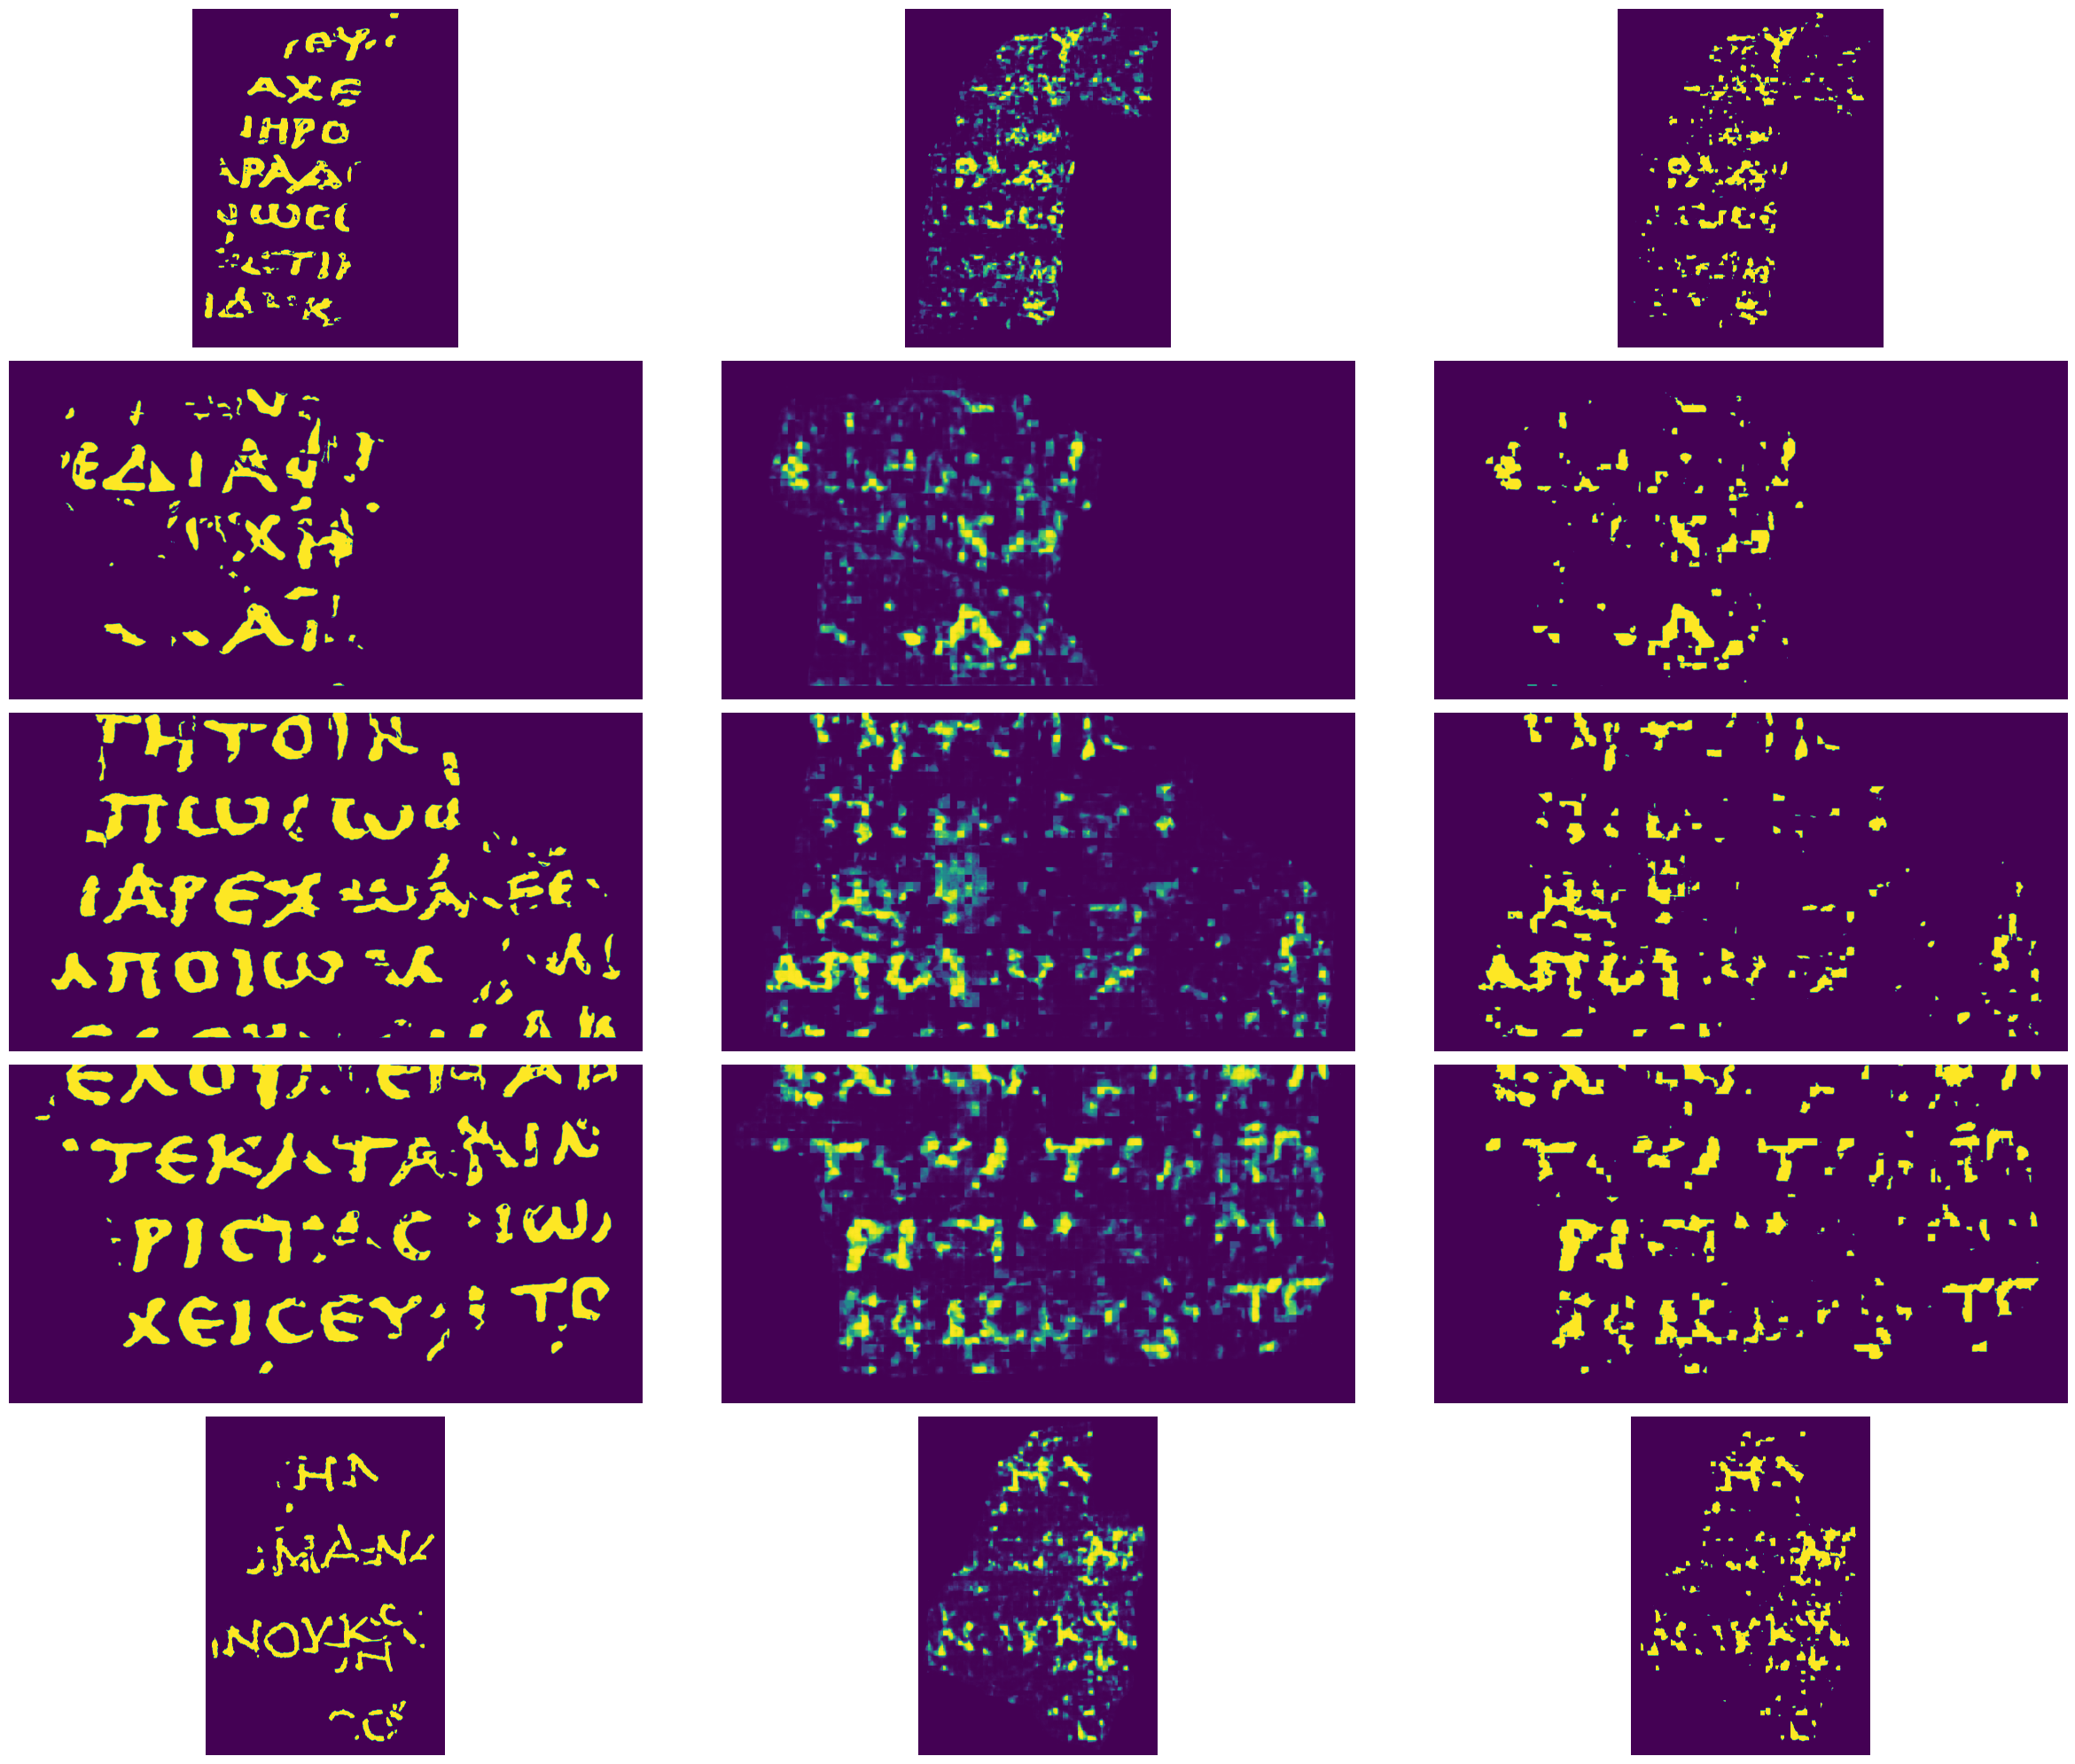

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)